# IG 2410 - Introduction to Artificial Intelligence

The following cell will load all the libraries used for the project.  
For the rest of this notebook, I'll separate the functions containing parts of the project from the main code, for clarity issues. Both will be labeled depending on their goal.

In [1]:
import pandas as pd
from sklearn import decomposition, naive_bayes, metrics, neighbors, preprocessing, linear_model, model_selection, cluster, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import mean, unique, asarray
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import math

from random import randint

import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

## Introduction: getting the data
### Loading some data
In order to work on this project, we first need to get some data.  
Accordingly to the instructions, there is a dataset available at the following link: https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data. 
The csv file was accessed and downloaded on 20.04.2020.
### Cleaning the dataset
The file I used had some missing data, fields with different syntax, different case, less useful columns... Which meant I needed to select the columns that seemed more useful to me and trim and clean the remaining data. More specifically:
- We categorised `country` and `sex` columns to convert strings into integers.  
- We cleaned the `outcome` column using a death dictionary to homogenise the data
- We cleaned the `age` column: any age range is either represented by the boundary (if there is only one) or the mean (if there are an upper and lower boundary)
- We deleted rows with missing data and reseted the indexes
- We normalised the data the compress the data range


In [2]:
# [Appendix 1]: loading and cleaning data
"""
    This is a dictionary of the death vocabulary used to clean the column 'outcome'
"""
__death__ = set(['dead', 'Dead', 'death', 'Death', 'deceased', 'Deceased', 'died', 'Died'])


"""
    output: raw data using the csv file
    --
    We load the data from covid.csv by default. It is the data downloaded from
    https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data
    The file covid.csv (available in /resources/covid.csv) has been downloaded on 20.04.2020.
"""
def loadData():
    return pd.read_csv('../resources/covid.csv', header=0,
                    dtype={'ID': str, 'age': str, 'sex': str, 'city': str, 'province': str, 'country': str,
                           'latitude': float, 'longitude': float, 'geo_resolution': str, 'date_onset_symptoms': str,
                           'date_admission_hospital': str, 'date_confirmation': str, 'symptoms': str,
                           'lives_in_Wuhan': str,
                           'travel_history_dates': str, 'travel_history_location': str, 'reported_market_exposure': str,
                           'additional_information': str, 'chronic_disease_binary': bool, 'chronic_disease': str,
                           'source': str, 'sequence_available': str, 'outcome': str, 'date_death_or_discharge': str,
                           'notes_for_discussion': str, 'location': str, 'admin3': str, 'admin2': str, 'admin1': str,
                           'country_new': str, 'admin_id': float, 'data_moderator_initials': str,
                           'travel_history_binary': str})


"""
    input: age or age range
    output: age or mean of the age range
    --
    For computation purpose, we need to get fix values. In case we get a range we will compute a mean. If we get an
    estimation, we will take the estimation boundaries.
"""
def to_float(list_str):
    if len(list_str) > 1 and (list_str[1] == "" or list_str[1] is None):
        return float(list_str[0])
    else:
        return mean([float(x) for x in list_str])


"""
    input: raw uncleaned data
    output: data used for part 1: Analysis of the dataset
    --
    For the part on the analysis of the dataset, we only need some data:
    { 'age', 'sex', 'outcome', 'country', 'chronic_disease_binary' }
    We trim the data to enable PCA and plotting of the data, as raw data was difficult to use.
"""
def trim(raw, norm=True):
    """
        Cleaning dataframe: we only use useful columns. List of data considered useful:
        { age, sex, country, chronic_disease_binary, outcome }
        For cleaning columns: https://realpython.com/python-data-cleaning-numpy-pandas/
    """
    data = raw.copy(deep=True)
    new_data = data.get(['age', 'sex', 'outcome', 'country', 'chronic_disease_binary'])  # get useful columns
    new_data = new_data.dropna()  # drops columns with incomplete data
    new_data = new_data.reset_index()  # reset indexes for later uses
    new_data = new_data.drop(['index'], axis=1)
    

    """
        Targeting: we add the target column (outcome).
        Cleaning the column:
            Any data in the death dictionary should be considered as (1).
            People that survived should be considered as (0).
            For later iterations, we could work with 3 states (dead, in hospital, recovered)
    """
    #  Death dictionary is defined in utils.py as __death__
    death_index = new_data['outcome'].isin(__death__)
    #  Adding the outcome column to the dataframe
    new_data['outcome'][death_index] = 1
    new_data['outcome'][~death_index] = 0

    """
        Normalization of data
        https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    """
    if norm:
        new_data['age'] = [to_float(x) for x in new_data['age'].astype(str).str.split('-')]
        new_data['country'] = new_data['country'].astype('category').cat.codes
        new_data['sex'] = new_data['sex'].astype('category').cat.codes
        scaled = StandardScaler().fit_transform(new_data.get(['age', 'sex', 'outcome', 'country', 'chronic_disease_binary']))
        new_data = pd.DataFrame(scaled, index=new_data.index, columns=new_data.columns)

    return new_data


In [3]:
# [Run this code]: loading and cleaning data
raw = loadData()
dataset = trim(raw)

## Analysis of the dataset
We now have a clean dataset in the variable `dataset`. The next step is to compute the correlations between each variable.  
The following figure shows the raw, untreated data.

<img src="../resources/raw.png"/>

### Correlation
After computing the correlation between the different columns, we obtain the following matrix (rounded up with 2 decimals):  

|                        | age   | sex   | outcome | country | chronic_disease_binary |
|------------------------|-------|-------|---------|---------|------------------------|
| age                    | 1.00  | -0.30 | 0.62    | 0.01    | 0.41                   |
| sex                    | -0.30 | 1.00  | 0.06    | -0.03   | 0.10                   |
| outcome                | 0.62  | 0.06  | 1.00    | 0.04    | 0.55                   |
| country                | 0.01  | -0.03 | 0.04    | 1.00    | 0.03                   |
| chronic_disease_binary | 0.41  | 0.10  | 055     | 0.03    | 1.00                   |

Focusing on the outcome column :  

```
| outcome                | 0.62  | 0.06  | 1.00    | 0.04    | 0.55                   |
```
Putting aside the `outcome x outcome` cell (obviously equal to 1), it seems that the outcome has the highest correlation with the age; the second highest being the absence or presence of chronic disease. Other columns (age and country) seem to have very low impact on the outcome.

Considering the correlation between the age and the outcome is superior to 60%, we can say they are strongly correlated. Likewise, we can say that outcome and presence of chronic disease is moderately correlated. 

### Principal Component Analysis (PCA)
Concerning the PCA, I used two components. These two components explain approximately 60% of the variance, which could be bettered using more components; however, according to Joseph F. Hair et al. article, Multivariate Data Analysis, a minimum of 60% should be achieved to construct a valid analysis. (https://is.muni.cz/el/1423/podzim2017/PSY028/um/_Hair_-_Multivariate_data_analysis_7th_revised.pdf)

<img src="../resources/pca.png"/>

In [4]:
# [Appendix 2]: Correlation and PCA

def plotRaw(dataset, fig_size = 6):
    f, axes = plt.subplots()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size)

    axes.set_title('Raw Data', fontsize=20)

    sexes = np.sort(np.unique(dataset['sex']))
    chronics = np.sort(np.unique(dataset['chronic_disease_binary']))
    colors = ['b', 'r']
    legends = ['male', 'female']
    legends_chr = ['male with chronic disease', 'female with chronic disease']

    for sex, color, legend in zip(sexes, colors, legends):
        sex_ = dataset['sex'] == sex
        chronics_ = dataset['chronic_disease_binary'] == chronics[0]
        cond = sex_ & chronics_
        axes.scatter(dataset.loc[cond, 'country'], dataset.loc[cond, 'age'], c=color, s=50, label=legend, alpha=0.3)

    for sex, color, legend in zip(sexes, colors, legends_chr):
        sex_ = dataset['sex'] == sex
        chronics_ = dataset['chronic_disease_binary'] == chronics[1]
        cond = sex_ & chronics_
        axes.scatter(dataset.loc[cond, 'country'], dataset.loc[cond, 'age'], c=color, s=50, label=legend, alpha=0.3,
                     marker='x')
    plt.xticks(rotation=90)
    axes.set_xlabel('Countries')
    axes.set_ylabel('Age')
    axes.legend(legends + legends_chr, loc=1)
    axes.grid()


"""
    input: dataset
    output: correlations between every given parameter
    --
    Computing Pearson correlation on data
    https://realpython.com/numpy-scipy-pandas-correlation-python/
"""
def computeCorrelations(df):
    xy_corr = []
    for x in df.columns:
        x_corr = []
        for y in df.columns:
            corr_xy = pearsonr(df[x], df[y])[0]
            x_corr.append(corr_xy)
        xy_corr.append(x_corr)

    return pd.DataFrame(xy_corr, index=df.columns, columns=df.columns)


"""
    input: dataset, number_of_principal_components, size_of_figure
    output: plot of the PCA of the dataset
    --
    Computing the PCA for the given dataset. The PCA  works on the following columns (deemed to be more interesting):
    { 'age', 'sex', 'country', 'chronic_disease_binary' }
    --
    PCA: https://emanuelfontelles.github.io/blog/Principal-Component-Analysis.html
    Correlation vectors: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
"""
def pcaOf(dataset, n_components=2, fig_size=8):
    pca_dataset = dataset.get(['age', 'sex', 'country', 'chronic_disease_binary']).copy()
    pca_ = decomposition.PCA(n_components=n_components)
    X_pca = pca_.fit_transform(pca_dataset)

    principalDf = pd.DataFrame(data=X_pca, columns=['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, dataset['outcome']], axis=1)

    explained_var = np.round(pca_.explained_variance_ratio_ * 100, decimals=2)

    f, axes = plt.subplots(1, 2)
    f.set_figheight(fig_size)
    f.set_figwidth(2*fig_size)

    axes[0].bar(x=range(len(explained_var)), height=explained_var, width=0.1, tick_label=['PC 1', 'PC2'])

    axes[1].set_title('2 component PCA', fontsize=20)
    targets = np.sort(np.unique(dataset['outcome']))
    colors = ['g', 'r']
    legends = ['alive', 'dead']
    for target, color, legend in zip(targets, colors, legends):
        indicesToKeep = finalDf['outcome'] == target
        axes[1].scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                     finalDf.loc[indicesToKeep, 'principal component 2'],
                     c=color, s=50, label=legend, alpha=0.3)
    axes[1].set_xlabel('PC1 - {0}%'.format(explained_var[0]))
    axes[1].set_ylabel('PC2 - {0}%'.format(explained_var[1]))
    axes[1].legend(legends)
    axes[1].grid()

    for i, (x, y) in enumerate(zip(pca_.components_[0, :], pca_.components_[1, :])):
        axes[1].arrow(0, 0, x, y, color='black', head_width=0.05, head_length=0.05)
        axes[1].text(x + 0.1, y, pca_dataset.columns[i], fontsize='9', weight="bold", ha="center")

    plt.draw()
    return X_pca

Table of correlations
                             age       sex   outcome   country  \
age                     1.000000 -0.029954  0.620376  0.009257   
sex                    -0.029954  1.000000  0.057938 -0.034419   
outcome                 0.620376  0.057938  1.000000  0.037338   
country                 0.009257 -0.034419  0.037338  1.000000   
chronic_disease_binary  0.409204  0.098687  0.547529  0.031890   

                        chronic_disease_binary  
age                                   0.409204  
sex                                   0.098687  
outcome                               0.547529  
country                               0.031890  
chronic_disease_binary                1.000000  
Correlations for outcome:
age                       0.620376
sex                       0.057938
outcome                   1.000000
country                   0.037338
chronic_disease_binary    0.547529
Name: outcome, dtype: float64
Best correlation with outcome: age (0.620376470985482)


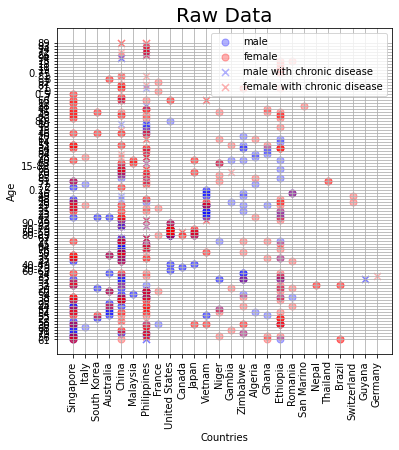

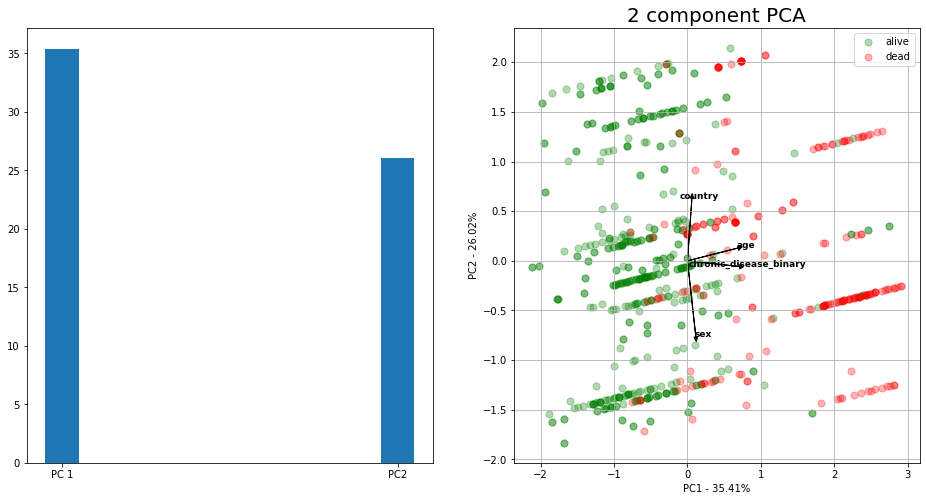

In [5]:
# [Run this code]: 
# === Plot raw === #
rawdata = trim(raw, norm=False)
plotRaw(rawdata)

# === Correlation === #
correlations = computeCorrelations(dataset)
print('Table of correlations')
print(correlations)
print('Correlations for outcome:')
print(correlations['outcome'])

# Getting the parameter that has highest correlation with 'outcome', excluding the result for 'outcome'x'outcome' (=1)
print('Best correlation with outcome: ' +
      str(correlations.index[correlations['outcome'] == correlations['outcome'].sort_values(ascending=False)[1]][0]) +
      ' (' + str(correlations['outcome'].sort_values(ascending=False)[1]) + ')')

# === PCA === #
pcaOf(dataset)

plt.show()


## Bayes Nets
In this part we use Bayes' theorem to get some probabilities and to predict some data.  
As we only used a few data (some of which were missing in my original trimmed and cleaned data), we reload a new dataframe to work with, still using the same csv file.

The following probabilities were computed:  

- P(S=1|W=1) = P(S=1,W=1)/P(W=1): 45.36082474226804%  
- P(C=1|S=1,W=1) = P(C=1,S=1,W=1)/P(S=1,W=1): 100.0%  
- P(O=1|W=1) = P(O=1,W=1)/P(W=1): 4.123711340206185%

Where:  
- S = Symptoms. S can be of value 0 (no symptoms found) or 1 (symptoms found)
- W = Wuhan visited. W can be of value 0 (Wuhan has not been visited) or 1 (Wuhan has been visited)
- C = Covid confirmed, and thus the patient is a true patient. C can be of value 0 (not a true patient) or 1 (patient is a true patient)
- O = Outcome. O can be of value 0 (patient did not die) or 1 (patient died)

Concerning the average recovery interval for a patient who visited Wuhan, these are my computed results:
- Minimal interval: -7 days
- Maximal interval: 29 days
- Average interval: 13.6 days

Surprisingly, the minimal interval is negative. It seems, once again, that the data could be enhanced somehow -- or it could be human error.

In [6]:
# [Appendix 3]: Bayes Nets
"""
    input: string data in column 'travel_history_location'
    output: integer data according to whether or not the person has visited Wuhan
    --
    Returns 1 if the person has visited Wuhan according to the database, returns 0 otherwise.
    If the data is missing, we will consider that the person did not visit Wuhan.
"""
def traveledToWuhan(travel_history):
    if 'wuhan' in travel_history.lower():
        return 1
    else:
        return 0


"""
    input: string data in column 'date_onset_symptoms'
    output: integer data according to whether or not the person has visited Wuhan
    --
    Returns 1 if the person has visited Wuhan according to the database, returns 0 otherwise.
    If the data is missing, we will consider that the person did not visit Wuhan.
"""
def gotCoroned(dateOfCoronavirus):
    if dateOfCoronavirus != 'nan':
        return 1
    else:
        return 0


"""
    input: raw uncleaned data
    output: data used for part 2: Bayes Nets
    --
    For the part on Bayes Nets, we only need some data:
    { 'date_confirmation', 'date_onset_symptoms', 'travel_history_location', 'outcome', date_death_or_discharge }
"""
def BN_data(raw):
    data = raw.copy(deep=True)
    new_data = data.get(
        ['date_confirmation', 'date_onset_symptoms', 'travel_history_location', 'outcome', 'date_death_or_discharge'])
    # As we build the columns using lack of data as a data (false), no need to drop incomplete columns using dropna()
    new_data['travel_history_location'] = [traveledToWuhan(x) for x in
                                           new_data['travel_history_location'].astype(str)]
    new_data['date_onset_symptoms'] = [gotCoroned(x) for x in new_data['date_onset_symptoms'].astype(str)]

    #  Death dictionary is defined in utils.py as __death__
    death_index = new_data['outcome'].isin(__death__)
    #  Adding the outcome column to the dataframe
    new_data['outcome'][death_index] = 1
    new_data['outcome'][~death_index] = 0

    new_data = new_data.dropna()  # Making sure no row is missing data, though it should not do anything
    return new_data


In [7]:
# [Run this code]:

# Loading new minimal data for this part
df = BN_data(raw)

n_total = len(df.index)
n_symptom_wuhan = len(df[(df['date_onset_symptoms'] == 1) & (df['travel_history_location'] == 1)])
n_wuhan = len(df[df['travel_history_location'] == 1])
n_truepatient_symptom_wuhan = len(df[(df['date_confirmation'].isnull() == False) & (df['date_onset_symptoms'] == 1) & (df['travel_history_location'] == 1)])
n_dead_wuhan = len(df[(df['outcome'] == 1) & (df['travel_history_location'] == 1)])

print("=== Probabilities ===")
print("=== Units - N(X): [case] - P(X): [%]  ===")
print("N_total:", n_total)
print("=== Q1 ===")
print("N(S=1,W=1):", n_symptom_wuhan)
print("N(W=1):", n_wuhan)
print("----------")
print("P(S=1,W=1):", 100*n_symptom_wuhan/n_total)
print("P(W=1):", 100*n_wuhan/n_total)
print("P(S=1|W=1) = P(S=1,W=1)/P(W=1):", 100*n_symptom_wuhan/n_wuhan)
print("=== Q2 ===")
print("N(C=1,S=1,W=1):", n_truepatient_symptom_wuhan)
print("N(S=1,W=1):", n_symptom_wuhan)
print("----------")
print("P(C=1,S=1,W=1):", 100*n_truepatient_symptom_wuhan/n_total)
print("P(S=1,W=1):", 100*n_symptom_wuhan/n_total)
print("P(C=1|S=1,W=1) = P(C=1,S=1,W=1)/P(S=1,W=1):", 100*n_truepatient_symptom_wuhan/n_symptom_wuhan)
print("=== Q3 ===")
print("N(O=1,W=1):", n_dead_wuhan)
print("N(W=1):", n_wuhan)
print("----------")
print("P(O=1,W=1):", 100*n_dead_wuhan/n_total)
print("P(W=1):", 100*n_wuhan/n_total)
print("P(O=1|W=1) = P(O=1,W=1)/P(W=1):", 100*n_dead_wuhan/n_wuhan)
print("=== Q4 ===")
dead = df['outcome'] == 0  # didnt die
wuhan = df['travel_history_location'] == 1  # visited wuhan
filter_ = dead & wuhan
recoveries = df.loc[filter_,['date_death_or_discharge', 'date_confirmation']]
recoveries['date_death_or_discharge'] = pd.to_datetime(recoveries['date_death_or_discharge'], format='%d.%m.%Y')
recoveries['date_confirmation'] = pd.to_datetime(recoveries['date_confirmation'], format='%d.%m.%Y')
rangeRecovery = (recoveries['date_death_or_discharge'] - recoveries['date_confirmation']).dt.days
print("Recovery for a person who visited Wuhan:")
print("Range (in days): [{min}, {max}]".format(min=rangeRecovery.min(), max=rangeRecovery.max()))
print("Average time for a recovery: {average} days".format(average=rangeRecovery.mean()))

=== Probabilities ===
=== Units - N(X): [case] - P(X): [%]  ===
N_total: 465
=== Q1 ===
N(S=1,W=1): 44
N(W=1): 97
----------
P(S=1,W=1): 9.46236559139785
P(W=1): 20.86021505376344
P(S=1|W=1) = P(S=1,W=1)/P(W=1): 45.36082474226804
=== Q2 ===
N(C=1,S=1,W=1): 44
N(S=1,W=1): 44
----------
P(C=1,S=1,W=1): 9.46236559139785
P(S=1,W=1): 9.46236559139785
P(C=1|S=1,W=1) = P(C=1,S=1,W=1)/P(S=1,W=1): 100.0
=== Q3 ===
N(O=1,W=1): 4
N(W=1): 97
----------
P(O=1,W=1): 0.8602150537634409
P(W=1): 20.86021505376344
P(O=1|W=1) = P(O=1,W=1)/P(W=1): 4.123711340206185
=== Q4 ===
Recovery for a person who visited Wuhan:
Range (in days): [-7, 29]
Average time for a recovery: 13.591397849462366 days


## Machine Learning
### Introduction
To use a KNN prediction model, we need a dataset: I used the initial trimmed and cleaned dataset (with `age`,`sex`,`outcome`,`country`, and `chronic_disease_binary` columns).  
### KNN
To build the KNN model, I splitted the dataset into two subsets for training and testing purposes. In this example, we split the data into 80%/20% ratio, respectively for training and testing.

To find the best accuracy, we have to vary the K number of nearest neighbours taken into account. In our tests, we made the number K vary between 1 and 10, then plotted the average accuracy of the predictions.

In order to reduce the bias due to the splitting of the initial dataset, I randomized the splitting using a seed and plotted the different accuracy outcomes, depending on the seed and making the number K vary.

<img src="../resources/knn.png"/>

From these results, we can estimate the best number K of nearest neighbours to take into account as 5.

Taking 5 as the K number of Nearest Neighbours for the algorithm, I obtained these results (for the seeds given in the figure):

|          | Accuracy of 5-NN | True positive | False positive | True negative | False negative |
|----------|------------------|---------------|----------------|---------------|----------------|
| Seed 64  | 88.4%            | 36            | 6              | 86            | 10             |
| Seed 26  | 91.3%            | 41            | 5              | 85            | 7              |
| Seed 3   | 87.7%            | 38            | 10             | 83            | 7              |
| Seed 62  | 88.4%            | 40            | 10             | 82            | 6              |
| Seed 84  | 89.9%            | 37            | 4              | 87            | 10             |
| Seed 50  | 84.8%            | 29            | 12             | 88            | 9              |
| Seed 6   | 89.1%            | 30            | 3              | 93            | 12             |
| Seed 39  | 85.5%            | 29            | 8              | 89            | 12             |
| Seed 28  | 91.3%            | 39            | 6              | 87            | 6              |
| Average  | 88.5%            | 35.4          | 7.1            | 87.8          | 8.8            |

I personally decided that a positive is a death, whereas a negative is a patient getting discharged.  
With these results, we have around 11,5% of wrong predictions (5.1% false positive and 6.3% false negative). In the end, we get 83.3% accuracy in predicting a death and 90.1% in predicting recovery.

In [8]:
# [Appendix 4]: Machine Learning -- KNN algorithm

"""
    input: dataset, target, splitting ratio, seed
    output: training_data, testing_data, training_target, expected_prediction
    --
    We split the data following a X/Y ratio:
    X is the ratio of data used for training
    Y is the ratio of data used for testing
    The seed is used to randomize the splitting of data. We can set results by setting the seed.
"""


def split_training_testing(X, Y, test_size=0.2, seed=randint(0, 100)):
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    lab_enc = preprocessing.LabelEncoder()
    Y_train = lab_enc.fit_transform(Y_train)
    Y_test = lab_enc.fit_transform(Y_test)
    return X_train, X_test, Y_train, Y_test


"""
    input: training_set, training_target, number_of_neighbors
    output: knn_model
    --
    To use the KNN algorithm, we have to use the settings.
"""


def fitTNN(X_train, Y_train, n_neighbors=10):
    knn = neighbors.KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, Y_train)
    return knn


"""
    input: testing_set, expected_prediction, knn_model
    output: results of the prediction
    --
    Using the KNN settings, we can predict the target. The function outputs one array per expected result (from the testing set).
    The array contains the prediction, the distance between the prediction and the actual goal, and the state of the prediction.
"""


def predictTNN(X_test, Y_test, knn):
    res = []
    for int_i in range(len(X_test)):
        entry_ = X_test[int_i]
        target_ = Y_test[int_i]
        prediction = knn.predict([entry_])
        dist = metrics.accuracy_score([target_], prediction)

        #  I decided that a positive is a death, whereas a negative is a patient getting discharged.
        result_confusion = 'true ' if target_ == prediction else 'false '
        result_confusion += 'positive' if prediction == 1 else 'negative'

        res.append([prediction[0], dist, result_confusion])
    return res


"""
    input: training_data, testing_data, training_target, expected_prediction, number_of_neighbors
    output: results of the prediction
    --
    We train the model, then predict outputs for the testing set using the training set.
"""


def TNN(X_train, X_test, Y_train, Y_test, n_neighbors):
    knn = fitTNN(X_train, Y_train, n_neighbors)
    predictions = predictTNN(X_test, Y_test, knn)
    return asarray(predictions)


"""
    input: array containing distances from prediction to expectation
    output: average accuracy of the KNN predictions
    --
    We return the mean of the accuracy of every prediction
"""


def percentageTNNGoodGuesses(distance_pred_to_goal):
    return distance_pred_to_goal.astype(np.float).sum() / len(distance_pred_to_goal)


"""
    input: state of the predictions
    output: count for each state
    --
    For every prediction, there is an associated state (https://en.wikipedia.org/wiki/Confusion_matrix). This function
    returns a count of every state.
"""


def TNNConfusionMatrix(confusion):
    uni, counts = unique(confusion, return_counts=True)
    return dict(zip(uni, counts))


"""
    input: dataset, targets, number_of_neighbors, seed
    output: plot of the variation of accuracy of KNN predictions, depending on the number of neighbors
    --
    In order to find the best number K of neighbors to use in the KNN algorithm, we can vary the number of neighbors and
    plot the accuracy of each KNN prediction. Modifying the seed splits the dataset differently and is useful to further
    remove biases from the search of the best K.
"""
def rangeKNN(X, Y, MAX_K_NEIGHBOUR=10, seed=randint(0, 100), index=0, axes=None):
    X_train, X_test, Y_train, Y_test = split_training_testing(X, Y, seed=seed)
    accuracies = []
    for k in range(1, MAX_K_NEIGHBOUR + 1):
        knn_res = TNN(X_train, X_test, Y_train, Y_test, k)
        accuracy = percentageTNNGoodGuesses(knn_res[:, 1])
        print("value of k (number of neighbours): " + str(k) + " - accuracy of KNN: " + str(accuracy))
        print(TNNConfusionMatrix(knn_res[:, 2]))
        accuracies.append(accuracy)

    row = int(index / 3)
    col = index % 3

    axes[row, col].plot(range(1, MAX_K_NEIGHBOUR + 1), accuracies, '.r-')
    axes[row, col].set_xlabel("Number of Nearest Neighbours")
    axes[row, col].set_ylabel("Accuracy")
    axes[row, col].set_xticks([])
    axes[row, col].set_title('K-NN (seed: ' + str(seed) + ')')

    
def plotKNNVariation(X,Y, max_k=10, iterations=9):
    fig, axes = plt.subplots(np.math.ceil(iterations / 3), min(iterations, 3))
    fig.set_figheight(3 * np.math.ceil(iterations / 3))
    fig.set_figwidth(3 * min(iterations, 3))

    for i in range(iterations):
        rndValue = randint(0, 100)
        rangeKNN(X, Y, max_k, seed=rndValue, index=i, axes=axes)
    plt.draw()

value of k (number of neighbours): 1 - accuracy of KNN: 0.9057971014492754
{'false negative': 9, 'false positive': 4, 'true negative': 87, 'true positive': 38}
value of k (number of neighbours): 2 - accuracy of KNN: 0.8840579710144928
{'false negative': 13, 'false positive': 3, 'true negative': 88, 'true positive': 34}
value of k (number of neighbours): 3 - accuracy of KNN: 0.8768115942028986
{'false negative': 8, 'false positive': 9, 'true negative': 82, 'true positive': 39}
value of k (number of neighbours): 4 - accuracy of KNN: 0.855072463768116
{'false negative': 12, 'false positive': 8, 'true negative': 83, 'true positive': 35}
value of k (number of neighbours): 5 - accuracy of KNN: 0.8913043478260869
{'false negative': 7, 'false positive': 8, 'true negative': 83, 'true positive': 40}
value of k (number of neighbours): 6 - accuracy of KNN: 0.8768115942028986
{'false negative': 9, 'false positive': 8, 'true negative': 83, 'true positive': 38}
value of k (number of neighbours): 7 - 

value of k (number of neighbours): 3 - accuracy of KNN: 0.8043478260869565
{'false negative': 15, 'false positive': 12, 'true negative': 82, 'true positive': 29}
value of k (number of neighbours): 4 - accuracy of KNN: 0.7971014492753623
{'false negative': 20, 'false positive': 8, 'true negative': 86, 'true positive': 24}
value of k (number of neighbours): 5 - accuracy of KNN: 0.8115942028985508
{'false negative': 17, 'false positive': 9, 'true negative': 85, 'true positive': 27}
value of k (number of neighbours): 6 - accuracy of KNN: 0.8115942028985508
{'false negative': 18, 'false positive': 8, 'true negative': 86, 'true positive': 26}
value of k (number of neighbours): 7 - accuracy of KNN: 0.8405797101449275
{'false negative': 13, 'false positive': 9, 'true negative': 85, 'true positive': 31}
value of k (number of neighbours): 8 - accuracy of KNN: 0.8188405797101449
{'false negative': 16, 'false positive': 9, 'true negative': 85, 'true positive': 28}
value of k (number of neighbours)

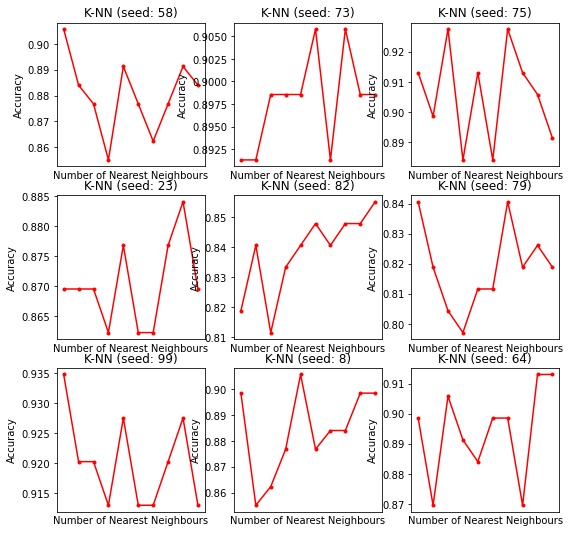

In [9]:
# K-Nearest Neighbours and Bayes Naive Classifier

# KNN with confusion matrix: target is 'outcome'
dataset = trim(raw)
X = dataset.copy(deep=False).drop(columns=['outcome']).to_numpy()
Y = dataset['outcome'].to_numpy()

plotKNNVariation(X,Y, max_k=10, iterations=9)
plt.show()

### Regression
The regression I chose to predict age (using regression) is the linear regression. I computed a prediction of age depending on all the other columns (namely `sex`, `outcome`, `country`, and `chronic_disease`).

*All the following values will change from one computation to another, as it is based on the splitting of the dataset into training and testing sets. These results were all taken from one single seed.*

I obtained various slopes for the linear regression's fit line and its intercept:

```
Slopes: -1.18, 12.1, -1.12,  3.00
Intercept: 48.5
```

I obtained a Mean Squared Error (MSE) of 379.67, which results in a Rooted MSE (RMSE) of 19.49 years. I prefer using the RMSE as it gives a value that can actually be used to compare the prediction to the expected target.
The r² score is negative, which was really surprising. (r² score: -0.16)

Seeing a RMSE of 19 years, I would say that using Linear Regression on this model does not yield good results. In my opinion, we are either lacking data, or the data is too incomplete, or it just is not predictible enough using Linear Regression.

I then decided to implement polynomial regression as I was not satisfied by the results. Considering the results were not quite different and that Polynomial Regression usually is quite accurate, I concluded that we are either lacking good data, or that I was trying to predict the age with the wrong parameters; however, I could not find better fields to use.

Polynomial Regression gave me these results:

```
Rooted Mean Squared Error: 19.97
Mean Squared Error: 398.98
r² score: -0.21
```

More testing shows that increasing the degree of the Polynomial Regression will worsen the predictions, so I ended up with using the results from Linear Regression.

I did not include graphical results, but they can be plotted in the code below (see `[Run this code]: Regression`).

In [10]:
# [Appendix 5]: Regression


def show_regression(results):
    [Y_testing, predictions] = results
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    x = np.arange(len(Y_testing))
    width = 0.35

    ax.bar(x - width / 2, Y_testing, width, label='Targets')
    ax.bar(x + width / 2, predictions, width, label='Predictions')
    ax.set_xlabel("Age Predictions")
    ax.set_ylabel("Age")
    ax.legend(loc=1)
    return predictions


def fitLinRegression(X_training, Y_training, X_testing, Y_testing):
    model = linear_model.LinearRegression()
    model.fit(X_training, Y_training)
    predictions = model.predict(X_testing)
    mse = metrics.mean_squared_error(Y_testing, predictions)

    print({"Slope:": model.coef_, "Intercept": model.intercept_})
    print(metrics.r2_score(Y_testing, predictions))
    print('Rooted Mean Squared Error:', np.sqrt(mse))
    print('Mean Squared Error:', mse)

    return [Y_testing, predictions]


def fitPolRegression(X_training, Y_training, X_testing, Y_testing, degree=2):
    polynomial_features = preprocessing.PolynomialFeatures(degree=degree)
    x_poly_train = polynomial_features.fit_transform(X_training)
    x_poly_test = polynomial_features.fit_transform(X_testing)
    fitLinRegression(x_poly_train, Y_training, x_poly_test, Y_testing)

In [11]:
# [Run this code]: Regression
dataset = trim(raw)
X = dataset.copy(deep=False).drop(columns=['age']).to_numpy()
Y = dataset['age'].to_numpy()

X_train, X_test, Y_train, Y_test = knn_cbn.split_training_testing(X, Y)

print("LINEAR REGRESSION")
predictions = knn_cbn.show_regression(knn_cbn.fitLinRegression(X_train, Y_train, X_test, Y_test))

print("POLYNOMIAL REGRESSION")
predictions = knn_cbn.show_regression(knn_cbn.fitPolRegression(X_train, Y_train, X_test, Y_test, degree=2))

plt.show()

NameError: name 'knn_cbn' is not defined

### Clustering
In order to find clusters, I applied K-means method on the dataset.

K-means method requires to know how many clusters we wish to have in the result: using the Silhouette index gives us.  
In my method `applyKmeans` which applies multiple times K-means method to the dataset, we can either give a set number of clusters to get or let the silhouette algorithm decide.

```
if not n_clusters:
    n_clusters = silhouette(X_pca)
```

In our model, `silhouette(X_pca)` will return 3: it is the optimal number of clusters.

<img src="../resources/kmeans.png"/>

Iterating multiple times the K-means algorithm shifts the data toward their centers, and relocates the computed centers. This allows for formation of clusters, as shown in the figure.


In [ ]:
# [Appendix 6]: Clustering

def applyKmeans(dataset, n_iterations, n_clusters=False):
    pca_ = decomposition.PCA(n_components=2)
    X_pca = pca_.fit_transform(dataset)

    if not n_clusters:
        n_clusters = silhouette(X_pca)

    fig, axes = plt.subplots(math.ceil(n_iterations / 3), min(n_iterations, 3))
    fig.set_figheight(3 * math.ceil(n_iterations / 3))
    fig.set_figwidth(3 * min(n_iterations, 3))
    for i in range(n_iterations):
        X_pca = it_kmeans(n_clusters, X_pca, pca_, i, axes)
    plt.draw()


def it_kmeans(n_clusters, X_pca, pca_, ii, axes):
    cl = cluster.KMeans(n_clusters=n_clusters)
    X_pca = cl.fit_transform(X_pca)

    new_labels = cl.labels_
    centers = cl.cluster_centers_
    kmeans_labels = ['Cluster ' + str(i) for i in range(1, n_clusters + 1)]
    explained_var = np.round(pca_.explained_variance_ratio_ * 100, decimals=2)

    colors = cm.rainbow(np.linspace(0, 1, len(kmeans_labels)))
    row = int(ii / 3)
    col = ii % 3

    for i in range(n_clusters):
        axes[row, col].scatter(X_pca[new_labels == i, 0], X_pca[new_labels == i, 1], c=rgb2hex(colors[i]),
                               label=kmeans_labels[i])
    axes[row, col].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8)
    axes[row, col].set_xlabel('PC1 - {0}%'.format(explained_var[0]))
    axes[row, col].set_ylabel('PC2 - {0}%'.format(explained_var[1]))

    return X_pca


def silhouette(X_pca, print_=False):
    kmeans_per_k = [cluster.KMeans(n_clusters=k).fit(X_pca) for k in range(1, 10)]
    silhouette_scores = [metrics.silhouette_score(X_pca, kmeans.labels_) for kmeans in kmeans_per_k[1:]]
    k = np.argmax(silhouette_scores) + 2
    if print_:
        plt.plot(range(2, 10), silhouette_scores, "bo-", color="blue")
        plt.scatter(k, silhouette_scores[k - 2], c='red', s=400)
    return k


In [ ]:
# [Run this code]: 

dataset = trim(raw).drop(['outcome'], axis=1)
applyKmeans(dataset, 9)

## Improving the results and Theoretical formalism
### Balancing the data by randomising
As said previously, the data is very unbalanced: I balanced it a bit by randomising the splitting of the data to training and testing sets.  

The reason I randomised the sets is to reduce the bias due to selecting the same values. Selecting random samples and computing the average for every value we analyse gives us a good overall view of the values, instead of commenting on a single sample which could possibly be a singularity among all the possible samples.  

Prediction results should vary from one to another, but they should all fit on a gaussian repartition, centered on the average prediction.

<img src="../resources/gaussian.png"/>

### Missing values
Currently, I discarded rows with missing values when I could not fill the data (exemple of filling the data: `symptom_onset` column, where I consider the lack of data as the lack of symptoms). This however lead to a huge part of the dataset disappearing: out of the initial 442822 rows in the csv, I only use 689 after cleaning and trimming.  
To better manage the missing values, I doubt replacing any missing values by their mean, median, or most represented value.


In [ ]:
plt.plot()